In [ ]:
import math

def get_tasks_for_thread(remainder: int, num_tasks_default: int, thread: int):
    num_tasks = num_tasks_default + 1 if thread < remainder else num_tasks_default
    threads_default = max(thread - remainder, 0)
    threads_default_plus = thread - threads_default
    start = threads_default * num_tasks_default + threads_default_plus * (num_tasks_default + 1)
    end = start + num_tasks - 1
    return num_tasks, start, end

def divide_tasks(tasks: int, threads: int):
    remainder = tasks % threads
    num_tasks_default = math.floor(tasks / threads)
    for thread in range(threads):
        num_tasks, start, end = get_tasks_for_thread(remainder, num_tasks_default, thread)
        print(f"Thread {thread}: tasks {start}-{end}, i.e. {num_tasks} tasks.")        

In [18]:
import wandb
import matplotlib.pyplot as plt

api = wandb.Api()
entity, project = "joasiee", "convergence_tests"  # set to your entity and project
runs = api.runs(entity + "/" + project)
names, configs, histories = [], [], []

for run in runs:
    if run.state == "finished":
        names.append(run.name)
        configs.append(
            {k: v for k, v in run.config.items()
             if not k.startswith('_')})
        history = run.history()
        history = history[history["R0/metric"] != 'NaN']
        histories.append(history)

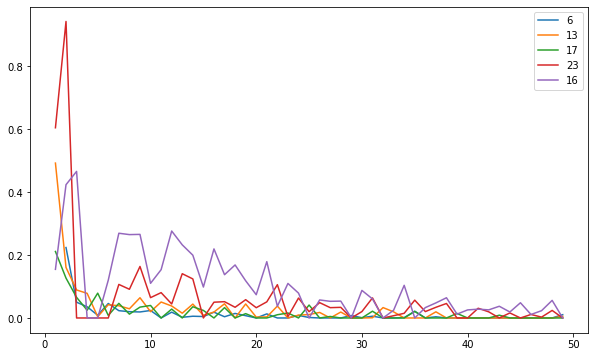

In [26]:
plt.figure(figsize=(10,6))
for i, history in enumerate(histories):
    history["R0/metric_pct"] = history["R0/metric"].pct_change().abs()
    history["R0/metric_pct"].plot.line(label=configs[i]["instance"])
plt.legend()

In [23]:
i = 0
sum = 0
for history in histories:
    i += 1
    sum += history.iloc[:41]["R0/time[ms]"].sum()
sum / i / 1000 / 60

65.990105